In [1]:
import numpy as np
import networkx as nx

import torch

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:

from filepath import *
from datamanip.plots import plot_rel_distribution, generate_matrix
from datamanip.feature_extraction import calculate_failure_rates
from datamanip.read_csvs import read_matrices, read_rel_values,merge_matrices_and_rel
from models.GAT import GAT#, GCN, SimpleMPNN
from train_eval.train import train
from train_eval.evaluate import evaluate

In [3]:
# Number of epochs to train the model
NUM_EPOCHS = 100

# Dropout rate for the model to prevent overfitting
DROPOUT_RATE = 0.3

# Learning rate for the optimizer
LEARNING_RATE = 0.0005

# Threshold for classifying reliability
THRESHOLD = 0.97

# Number of features for each node in the graph
NODE_FEATURES = 5

# Number of epochs to wait for improvement before early stopping
PATIENCE = 15

# Flag to indicate whether to use only one timestamp
ONE_TIMESTAMP = False

In [4]:


# Read matrices and reliability values into one DataFrame
all_matrices_df = read_matrices(matrices_path)
all_rels_df = read_rel_values(reliabilities_path, config_all_path)
merged_df = merge_matrices_and_rel(all_matrices_df, all_rels_df)

# Explode the 'timestamp' and 'reliability' columns
merged_df_exploded = merged_df.explode(['timestamp', 'reliability']).reset_index(drop=True)

# Display the exploded DataFrame
# print(merged_df_exploded)
print(merged_df_exploded.tail(10))
print(merged_df_exploded.shape)

                                                   matrix  config_id  \
167726  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         99   
167727  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         99   
167728  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         99   
167729  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         99   
167730  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         99   
167731  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         99   
167732  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         99   
167733  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         99   
167734  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         99   
167735  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         99   

       timestamp reliability  
167726     45500     0.24779  
167727     46000    0.243932  
167728     46500    0.240131  
167729     47000    0.236387  
167730     47500      0.2327  
167731     48000    0

In [5]:
# If the ONE_TIMESTAMP flag is set to True, filter the DataFrame to include only rows with a timestamp of 1000
if ONE_TIMESTAMP:
  merged_df_exploded = merged_df_exploded.loc[merged_df_exploded['timestamp'] == 1000]
  # Reset the index of the DataFrame after filtering
  merged_df_exploded = merged_df_exploded.reset_index(drop=True)

# Display the shape of the DataFrame
merged_df_exploded.shape


(167736, 4)

In [6]:
#Convert the matrices to edge indices

all_edge_indices : list[torch.Tensor] = []

merged_df_exploded['matrix'] = merged_df_exploded['matrix'].apply(np.array)

for _, row in merged_df_exploded.iterrows():
    matrix_np = row['matrix']

    # Get the indices where there are edges (i.e., non-zero entries)
    edge_indices = np.nonzero(matrix_np)

    # Stack the indices into a 2xN array where each column represents an edge
    edge_index = torch.tensor(np.vstack(edge_indices), dtype=torch.long)

    # Append the edge_index tensor to the list
    all_edge_indices.append(edge_index)

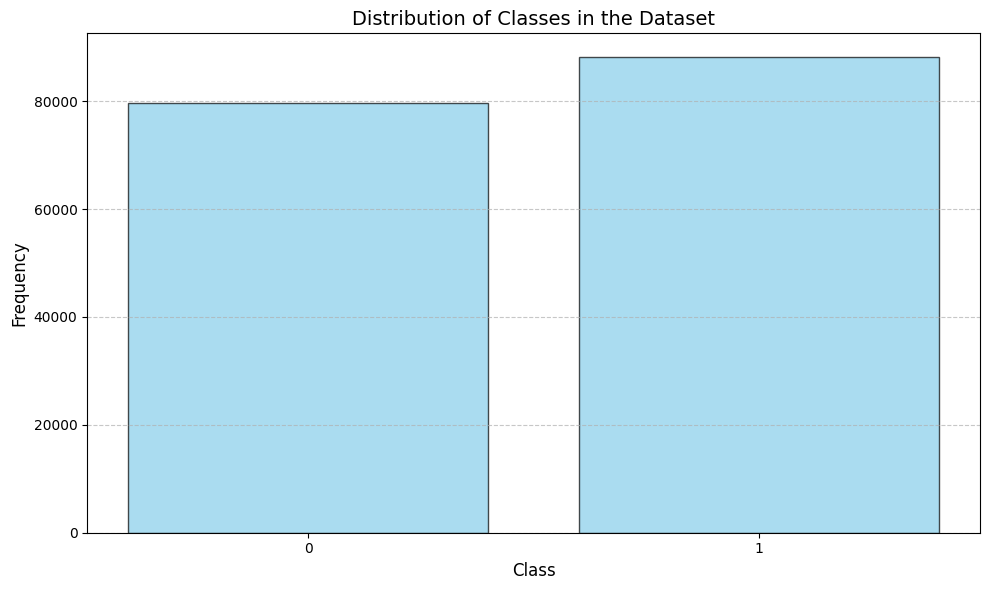

In [7]:
# Convert the reliability values to classes (two classes: 0 and 1)
all_rels : list[int] = []

for _, row in merged_df_exploded.iterrows():
    reliability = row['reliability']
    if reliability >= THRESHOLD:
      all_rels.append(1)
    else:
      all_rels.append(0)
#Assumes that classes in the list are integers (0 or 1 for binary case, 0,1,2,3,4.... for multiclass case)
plot_rel_distribution(all_rels)
all_rels_tensor : torch.Tensor = torch.tensor(all_rels)

In [8]:
#Create node features for the GNN
num_features = NODE_FEATURES

all_node_features = []
for _, row in tqdm(merged_df_exploded.iterrows()):
    
  adj_matrix  = row['matrix'] # Matrix of the graph
  timestamp = row['timestamp'] # Timestamp when reliability was measured
  num_nodes = adj_matrix.shape[0] # Number of nodes in the graph
  node_features = np.zeros((num_nodes, num_features)) # Initialize node features
    
  #Get indegree and centrality using NetworksX graph
  G = nx.from_numpy_array(adj_matrix)

  # Calculate centrality measures
  degree_centrality = nx.degree_centrality(G)
  closeness_centrality = nx.closeness_centrality(G)
  degree = adj_matrix.sum(axis=1)
  # Calculate failure rates based on given topology parameters
  failure_rates = calculate_failure_rates()

  # Assign features to each node
  for node in G.nodes():
      node_features[node, 0] = degree_centrality[node]
      node_features[node, 1] = closeness_centrality[node]
      node_features[node, 2] = degree[node]
      node_features[node, 3] = timestamp
      node_features[node, 4] = failure_rates[node]

  all_node_features.append(node_features)
node_features_tensor = torch.tensor(np.array(all_node_features), dtype=torch.float)

167736it [01:53, 1481.07it/s]


In [9]:
#Create list of Data objects, each containing the node features, edge indices, and target values
data_list = []

for i, row in merged_df_exploded.iterrows():
  node_features = node_features_tensor[i]
  edge_index = all_edge_indices[i]
  y = all_rels[i]
  data = Data(x=node_features, edge_index=edge_index, y=y)
  data_list.append(data)

In [10]:
# Split into training and testing data
train_data_list, test_data_list  = train_test_split(data_list, test_size=0.2, random_state=42)

# Further split training data into training and validation
train_data_list, val_data_list = train_test_split(train_data_list, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 validation split

# Create DataLoaders
train_loader = DataLoader(train_data_list, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_data_list)}")
print(f"Validation samples: {len(val_data_list)}")
print(f"Test samples: {len(test_data_list)}")


Training samples: 100641
Validation samples: 33547
Test samples: 33548


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(input_dim=NODE_FEATURES, hidden_dim=64, output_dim=2, dropout_rate=DROPOUT_RATE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

In [12]:
train_config = {
    "num_epochs": NUM_EPOCHS,
    "patience": PATIENCE,
    "device": device,
    "criterion": criterion,
    "optimizer": optimizer,
}

In [ ]:
train(model, train_loader, val_loader, train_config, model_checkpoints_path + "best_model_GAT.pth")

Epoch 1/100, Train Loss: 0.1933
Epoch 1/100, Validation Loss: 0.5078
Best model updated based on validation loss.


In [51]:
# Load the best model after training
model.load_state_dict(torch.load(model_checkpoints_path + "best_model_GAT.pth", weights_only=True))

<All keys matched successfully>

In [52]:
true_values, predicted_values, accuracy = evaluate(device, model, test_loader, model_checkpoints_path + "best_model_GAT.pth")

GAT(
  (conv1): GATConv(5, 64, heads=1)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(64, 32, heads=1)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Accuracy: 0.9579


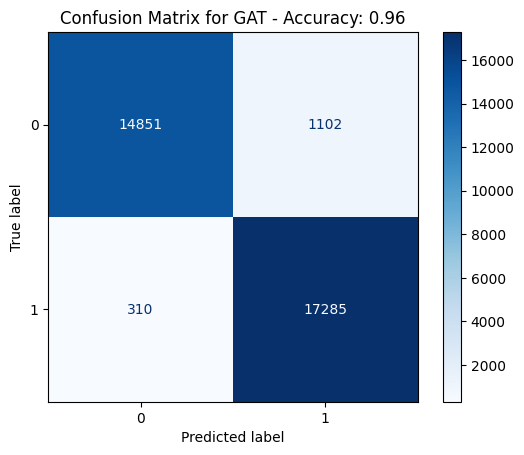

In [53]:
generate_matrix(true_values, predicted_values, accuracy, "GAT")